# Final Model Analysis Summary

In [11]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, make_scorer, accuracy_score
from sklearn.model_selection import cross_validate

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data  import TensorDataset, DataLoader
import torchmetrics

import pickle


## Base Models

A set of base models is implemented to act as a baseline to compare the final model. The set includes a K-Neighbors Classifier, a Decision Tree, a Gradient Boosting, a Random Forest, a Linear Discriminant Analysis, and a Logistic Regression model. The models will be compared, and a feature importance plot will be plotted using the best-performing model.

The models to be implemented are first defined inside a dictionary. A results list is instantiated to save the model score results. Since this is a classification problem, the metrics of interest will be *accuracy*, *precision* and *recall*. *Precision* can be viewed as the accuracy of the positive predictions; it can be calculated as follows:

$$precision = \frac{TP}{TP + FP},$$

where $TP$ is the number of true positives, and $FP$ is the number of false positives. This metric is usually reported alongside *recall*, also called *sensitivity* or the *true positive rate* (TPR). *Recall* is the ratio of positive instances that are correctly classified. *Recall* can be calculated as follows:

$$recall = \frac{TP}{TP + FN},$$

where $TP$ is the number of true positives and $FN$, the number of false negatives [(Aurelian Géron, 2023)](#ref-Geron2023).

In the `model_training_and_evaluation` notebook, the different preprocessing datasets were tested on the base models to identify the preprocessing that provided the best model performance. The data with the 'Non-Applicable' category proved to be the one providing the highest accuracy on the validation set. This is the dataset which will be used in the final model; passengers who answered questions using ‘Non-Applicable’ were given a separate category, and the missing values for the 'Arrival Delay in Minutes' feature were computed using the Iterative Imputer, with an `initial_strategy` set to the ‘mean'.

In [2]:
# Importing the data:
non_applicable_imputed = pd.read_pickle('../Data/Preprocessed/non_applicable_imputed.pkl')

In [41]:
# Splitting the data into features and responses:
X = non_applicable_imputed.drop(columns = 'Satisfaction', axis = 1)
y = non_applicable_imputed['Satisfaction']

# Scaling the data:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

To avoid overfitting, K-fold cross-validation (with ten splits) is used. K=10 was chosen as a generally acceptable number for this method. The results from the cross-validation are stored in a pickle file for further use. 

In [ ]:
# Defining the four models:
models = {'KNN': KNeighborsClassifier(),
          'Decision Tree': DecisionTreeClassifier(),
          'Gradient Boosting': GradientBoostingClassifier(),
          'Random Forest': RandomForestClassifier(),
          'Linear Discriminant Analysis': LinearDiscriminantAnalysis(),
          'Logistic Regression': LogisticRegression()}

# Storing the results:
results = []

# Defining the scoring metrics:
scoring = {'accuracy': make_scorer(accuracy_score),
           'precision': make_scorer(precision_score),
           'recall': make_scorer(recall_score)}

# Performing the cross-validation:
for name, model in models.items():
    kf = KFold(n_splits=10, random_state=42, shuffle=True)
    cv_results = cross_validate(model, X_scaled, y, cv=kf, scoring = scoring, return_train_score = False)
    
    # Saving the results:
    results.append({
        'Model': name,
        'Accuracy': cv_results['test_accuracy'],
        'Precision': cv_results['test_precision'],
        'Recall': cv_results['test_recall']
    })

# Creating a long-format data frame:
rows = []

for model_dict in results:
    model_name = model_dict.pop('Model')
    for metric_name, metric_values in model_dict.items():
        for value in metric_values:
            rows.append({'Model': model_name, 'Metric': metric_name, 'Value': value})

results_long = pd.DataFrame(rows)

# Saving results:
results_long.to_pickle('../Models/Imputation_Model_4/results_nonapplicable_mode_model.pkl')

The results are now printed, and accuracy plots are presented for comparison. 

                                           Value
Model                        Metric             
Decision Tree                Accuracy   0.945546
                             Precision  0.953385
                             Recall     0.950359
Gradient Boosting            Accuracy   0.943987
                             Precision  0.941742
                             Recall     0.960561
KNN                          Accuracy   0.928001
                             Precision  0.914205
                             Recall     0.963335
Linear Discriminant Analysis Accuracy   0.872363
                             Precision  0.877534
                             Recall     0.900406
Logistic Regression          Accuracy   0.875616
                             Precision  0.878800
                             Recall     0.905350
Random Forest                Accuracy   0.965179
                             Precision  0.958047
                             Recall     0.981519


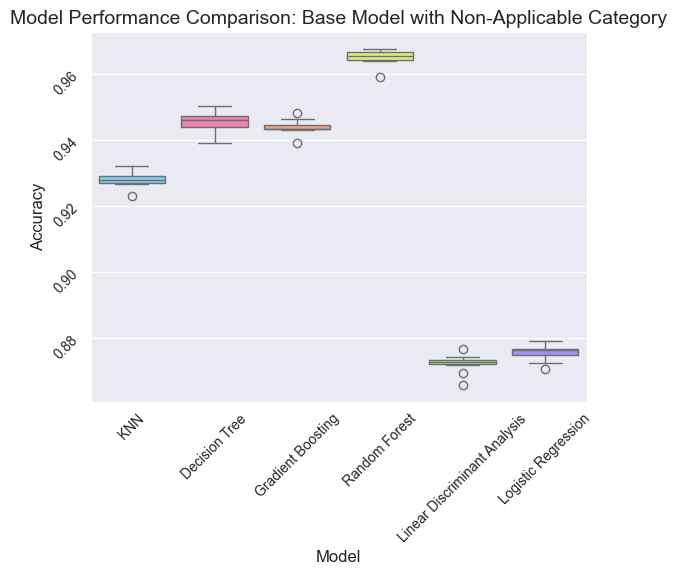

In [42]:
# Loading the results:
results_long = pd.read_pickle('../Models/Imputation_Model_4/results_nonapplicable_mode_model.pkl')

# Formatting the results for printing:
results = results_long.groupby(['Model', 'Metric']).mean()
results = pd.DataFrame(results)
print(results)

# Formatting data for multiple boxplots plot:
results_boxplot = results_long[results_long['Metric'] == 'Accuracy'].drop('Metric', axis = 1)

# Plotting the boxplots:
sns.set_style('darkgrid')
ax = sns.boxplot(x='Model', y='Value', hue='Model', data=results_boxplot, palette = ['#70D6FF', '#FF70A6', '#FF9770', '#E9FF70', '#AAF683', '#9381FF'])

# Customizing the plots:
ax.set_title('Model Performance Comparison: Base Model with Non-Applicable Category', fontsize = 14)
ax.set_xlabel('Model', fontsize = 12)
ax.set_ylabel('Accuracy', fontsize = 12)
ax.tick_params(axis='both', labelsize = 10, rotation = 45)

The Random Forest algorithm performed substantially better than the other models; it achieved an accuracy of 0.9652, a precision of 0.9580, and a recall of 0.9815. These results will be compared to those of the final model.

### Feature Importance Plot

The Random Forest model is now used to plot the importance of features, the most important features driving customer satisfaction outcomes.

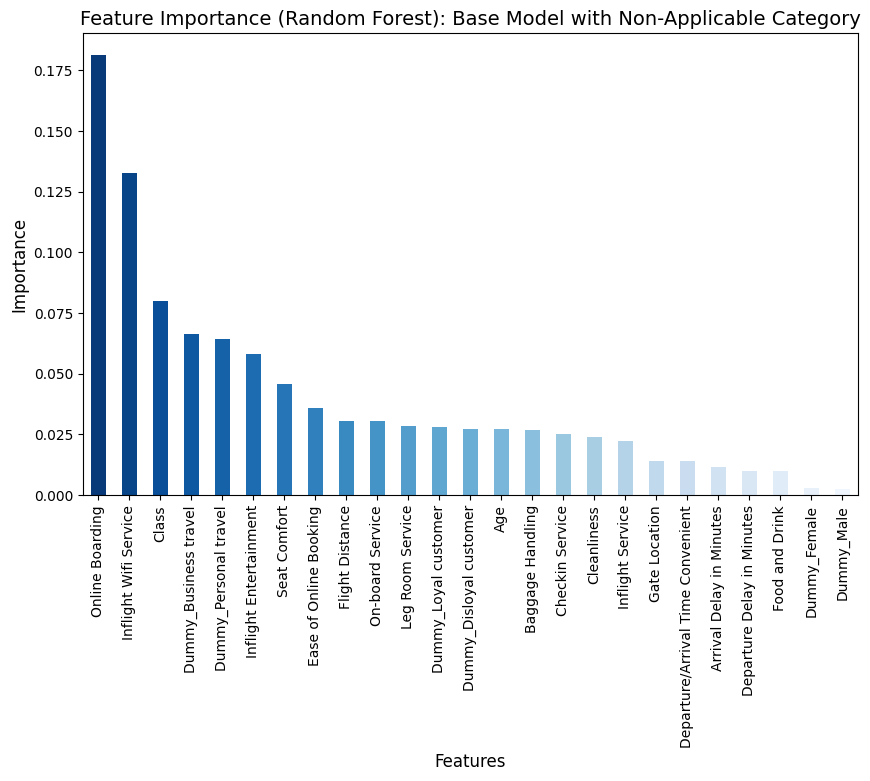

In [12]:
# Opening the results:
model_pkl_file = '../Models/Imputation_Model_4/model_rf.pkl'
with open(model_pkl_file, 'rb') as file:
        model_rf = pickle.load(file)

# Plotting the feature importance:
importance = pd.Series(model_rf.feature_importances_, index=X.columns)
colors = list(reversed(sns.color_palette("Blues", len(importance))))
ax = importance.sort_values(ascending=False).plot(kind='bar', color=colors, figsize=(10, 6))
    
# Customising the plot:
ax.set_xlabel('Features', fontsize=12)
ax.set_ylabel('Importance', fontsize=12)
ax.set_title('Feature Importance (Random Forest): Base Model with Non-Applicable Category', fontsize=14)
ax.tick_params(axis='both', labelsize=10)
plt.show()


The plot shows that the main features driving customer satisfaction are `Online Boarding`, `Inflight Wi-Fi Service`, and `Class`. Unsurprisingly, the passenger's sex has the least impact on customer satisfaction.

## Deep Neural Network

This neural network will use the data with the 'Non-Applicable' category since it provides the best results using standard machine learning algorithms.

In [90]:
non_applicable_imputed = pd.read_pickle('../Data/Preprocessed/non_applicable_imputed.pkl')

non_applicable_imputed.shape

(103904, 27)

Below are all the necessary procedures for using the data in a neural network:

In [91]:
# Splitting the data into features and responses:
X = non_applicable_imputed.drop(columns = 'Satisfaction', axis = 1)
y = non_applicable_imputed['Satisfaction']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

# Scaling the data:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Encoding the target:
encoder = LabelEncoder()
encoder.fit(y)
y_train_encoded = encoder.transform(y_train)
y_test_encoded = encoder.transform(y_test)

# Creating the train_dataset and the trainloader:
train_dataset = TensorDataset(torch.tensor(X_train_scaled).float(), torch.tensor(y_train_encoded).reshape(-1, 1).float())
trainloader = DataLoader(train_dataset, batch_size = 1000, shuffle = True)

# Creating the test_dataset and the validation loader:
test_dataset = TensorDataset(torch.tensor(X_test_scaled).float(), torch.tensor(y_test_encoded).reshape(-1, 1).float())
testloader = DataLoader(test_dataset, batch_size = 1000, shuffle = True)

The final model is a deep neural network with four linear layers and 88,501 parameters. The final layer is Linear since the `BCEWithLogitsLoss` is used as the criterion. This loss combines a Sigmoid layer and BCELoss into a single class [(PyTorch Contributors, 2023)](#ref-pytorch2023). An Adam Optimiser is used, and its hyperparameters have been tuned manually.

In [92]:
# Defining the model:
model = nn.Sequential(nn.Linear(26, 300),
                      nn.ReLU(),
                      nn.Dropout(p = 0.5),
                      nn.Linear(300, 200),
                      nn.ReLU(),
                      nn.Linear(200, 100),
                      nn.ReLU(),
                      nn.Dropout(p = 0.5),
                      nn.Linear(100, 1),
)

# Defining the criterion:
criterion = nn.BCEWithLogitsLoss()

# Defining the optimiser:
optimizer = optim.Adam(model.parameters(), lr=0.002, 
                       weight_decay=1e-4, betas=(0.8, 0.999))

# Creating accuracy metric:
metric = torchmetrics.Accuracy(task = 'binary')

A function is defined to run 100 epochs for the final model. The training loss and accuracy and the test loss and accuracy will be saved so that the results can be plotted later. The best model will also be tracked based on its validation accuracy. Each epoch includes both training and evaluation modes.

In [93]:
def run_100_epochs(number = 1):
    # Setting the number of epochs:
    epochs = 100

    # Instantiating metric results for plotting:
    epoch_train_loss_storage = []
    epoch_test_loss_storage = []
    epoch_train_accuracy_storage = []
    epoch_test_accuracy_storage = []

    # Instantiation variables to track the best model based on validation accuracy:
    best_val_accuracy = 0.0 
    best_model_state = None

    # Building the epoch loop:
    for epoch in range(epochs):
        
        # Setting the model to training mode:
        model.train()

        # Setting the training loss and accuracy to 0:
        training_loss = 0
        training_accuracy = 0

        # Building a loop for the train set data loader:
        for i, data in enumerate(trainloader, 0):
            
            # Starting a training loop:
            model.train()
            # Setting the gradients to zero:
            optimizer.zero_grad()
            # Getting the feature and target from the data loader:
            feature, target = data
            # Runing the forward pass:
            prediction = model(feature)
            # Calculating the loss:
            loss = criterion(prediction, target)
            # Storing the loss values for plotting:
            training_loss += loss.item()
            # Calculating accuracy over the batch:
            accuracy = metric(prediction, target)
            training_accuracy += accuracy.item()
            # Getting the gradients:
            loss.backward()
            # Updating the parameters:
            optimizer.step()

        # Storing the results of interest for plotting:
        epoch_train_loss = training_loss / len(trainloader)
        epoch_train_loss_storage.append(epoch_train_loss)
        epoch_train_accuracy = training_accuracy / len(trainloader)
        epoch_train_accuracy_storage.append(epoch_train_accuracy)

        # Setting the validation loss and accuracy to 0:
        validation_loss = 0
        validation_accuracy = 0

        # Setting the model to evaluation mode:
        model.eval()

        # Building a loop for the test set data loader:
        with torch.no_grad():
            for i, data in enumerate(testloader, 0):

                # Starting an evaluation loop:
                model.eval()
                # Getting the feature and target from the data loader:
                feature, target = data
                # Running the forward pass:
                prediction = model(feature)
                # Calculating the loss:
                loss = criterion(prediction, target)
                # Calculating accuracy over batch:
                accuracy = metric(prediction, target)
                validation_accuracy += accuracy.item()
                validation_loss += loss.item()

        # Storing the results of interest for plotting:
        epoch_test_loss = validation_loss / len(testloader)
        epoch_test_loss_storage.append(epoch_test_loss)
        epoch_test_accuracy = validation_accuracy / len(testloader)
        epoch_test_accuracy_storage.append(epoch_test_accuracy)

        # Check if this is the best model based on validation accuracy (or loss):
        if epoch_test_accuracy > best_val_accuracy:
            best_val_accuracy = epoch_test_accuracy
            best_model_state = model.state_dict()

        # Setting the model back to training mode:
        model.train()

        # Printing out what's happening every ten epochs:
        if epoch % 10 == 0:
            print(f"Epoch: {epoch} | Train Loss: {epoch_train_loss:.5f}| Test loss: {epoch_test_loss:.5f}")

    # Saving the best model based on validation accuracy:
    if best_model_state:
        torch.save(best_model_state, ("../Models/Neural_Nets/best_model_{}.pth").format(number))
        print(f"\nBest model saved with validation accuracy: {best_val_accuracy:.5f}")

    # Resetting the metrics:
    metric.reset() 

    # Saving the lists using pickle:
    with open(f'../Models/Neural_Nets/training_losses_{number}.pkl', 'wb') as file:
        pickle.dump(epoch_train_loss_storage, file)
    with open(f'../Models/Neural_Nets/test_losses_{number}.pkl', 'wb') as file:
        pickle.dump(epoch_test_loss_storage, file)
    with open(f'../Models/Neural_Nets/train_accuracies_{number}.pkl', 'wb') as file:
        pickle.dump(epoch_train_accuracy_storage, file)
    with open(f'../Models/Neural_Nets/validation_accuracies_{number}.pkl', 'wb') as file:
        pickle.dump(epoch_test_accuracy_storage, file)

    return epoch_train_loss_storage, epoch_test_loss_storage, epoch_train_accuracy_storage, epoch_test_accuracy_storage

Functions are defined to plot the training and validation loss and the training and validation accuracy, which have been saved during the one hundred epochs. Plotting these results ensures the model is stable and can be used for predictions on the final test set. 

In [76]:
def plot_loss(training_loss, validation_loss):    
    plt.plot(training_loss)
    plt.plot(validation_loss)
    plt.legend(['training loss', 'validation loss'])
    plt.xlabel('Epoch')
    plt.title('Training and Validation Loss')
    plt.show()

In [77]:
def plot_accuracy(training_accuracy, validation_accuracy):
    plt.plot(training_accuracy)
    plt.plot(validation_accuracy)
    plt.legend(['training accuracy', 'validation accuracy'])
    plt.xlabel('Epoch')
    plt.title('Training and Validation Accuracy')
    plt.show()


In [78]:
train_losses, test_losses, train_accuracy, test_accuracy = run_100_epochs(70)

Epoch: 0 | Train Loss: 0.30425| Test loss: 0.19056
Epoch: 10 | Train Loss: 0.10302| Test loss: 0.09237
Epoch: 20 | Train Loss: 0.09083| Test loss: 0.08810
Epoch: 30 | Train Loss: 0.08696| Test loss: 0.08313
Epoch: 40 | Train Loss: 0.08474| Test loss: 0.08368
Epoch: 50 | Train Loss: 0.08402| Test loss: 0.08210
Epoch: 60 | Train Loss: 0.08087| Test loss: 0.08140
Epoch: 70 | Train Loss: 0.08058| Test loss: 0.08200
Epoch: 80 | Train Loss: 0.07893| Test loss: 0.08269
Epoch: 90 | Train Loss: 0.07844| Test loss: 0.08162

Best model saved with validation accuracy: 0.96614


This model's best validation accuracy is 0.96614. The training and validation losses are plotted below to ensure the model's performance is stable.

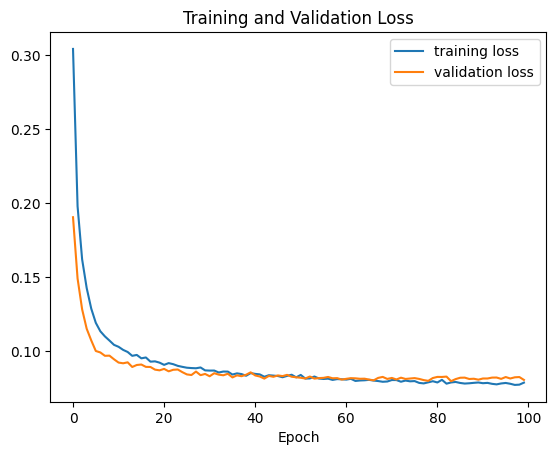

In [99]:
with open(f'../Models/Neural_Nets/training_losses_70.pkl', 'rb') as file:
       train_losses = pickle.load(file)
with open(f'../Models/Neural_Nets/test_losses_70.pkl', 'rb') as file:
       test_losses = pickle.load(file)

plot_loss(train_losses, test_losses)

The graph above demonstrates the model's stable performance. The same graph is plotted for the accuracy.

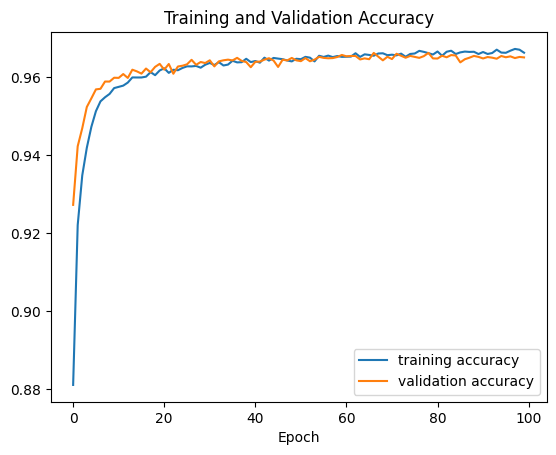

In [100]:
with open(f'../Models/Neural_Nets/train_accuracies_70.pkl', 'rb') as file:
       train_accuracies = pickle.load(file)
with open(f'../Models/Neural_Nets/validation_accuracies_70.pkl', 'rb') as file:
       test_accuracies = pickle.load(file)

plot_accuracy(train_accuracies, test_accuracies)

The 'Training and Validation Accuracy' graph shows the model's stable performance.

## Final Predictions

The final test data set will be imported and processed further. Model number 15 (from the `model_training_and_evaluation.ipynb` notebook) will be used to predict customer satisfaction on the test set. It is exactly the same as model number 70 (above) but achieved better overall accuracy during that run. An accuracy score and confusion matrix will show how the model performs on new data. 

In [96]:
# Importing the preprocessed data set:
test = pd.read_pickle('../Data/Preprocessed/test_preprocessed.pkl')

test.shape

(25976, 27)

In [97]:
# Splitting the data into features and response:
X = test.drop(columns = 'Satisfaction', axis = 1)
y = test['Satisfaction']

# Scaling the data:
X_scaled = scaler.transform(X)

# Encoding the target:
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)

# Creating the test_dataset and the validation loader:
test_dataset = TensorDataset(torch.tensor(X_scaled).float(), torch.tensor(y_encoded).reshape(-1, 1).float())
testloader = DataLoader(test_dataset, batch_size = 1000, shuffle = True)

/var/folders/1z/2qtxqpxj07g0pvc7h463fm_w0000gn/T/ipykernel_90968/3964439759.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("../Models/N

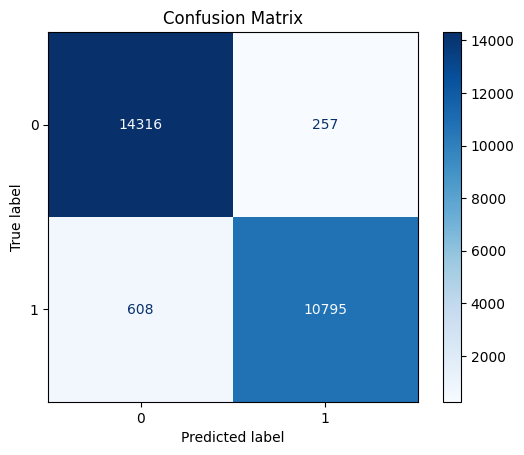

Test Accuracy: 0.9667
Precision: 0.97675
Recall: 0.94668


In [98]:
# Loading the saved model state dictionary:
model.load_state_dict(torch.load("../Models/Neural_Nets/best_model_15.pth"))
model.eval()

# Instantiating containers for all predictions and true labels:
all_predictions = []
all_true_labels = []

# Performing the evaluation loop over the test set:
with torch.no_grad():
    for features, targets in testloader:
        outputs = model(features)
        probabilities = torch.sigmoid(outputs)
        predicted_labels = (probabilities >= 0.5).float()
        all_predictions.extend(predicted_labels.cpu().numpy())
        all_true_labels.extend(targets.cpu().numpy())

# Converting the collected predictions and true labels to numpy arrays:
all_predictions = np.array(all_predictions).reshape(-1)
all_true_labels = np.array(all_true_labels).reshape(-1)

# Saving predictions to CSV:
prediction_df = pd.DataFrame(all_predictions, columns=["Predictions"])
prediction_df.to_csv("../Data/Predictions/prediction.csv", index=False)

# Saving the labels to csv:
labels_df = pd.DataFrame(all_true_labels, columns=["Labels"])
labels_df.to_csv("../Data/Predictions/labels.csv", index = False)

# Making a confusion matrix:
cm = confusion_matrix(all_true_labels, all_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Calculating the final accuracy:
final_accuracy = (all_predictions == all_true_labels).mean()
print("Test Accuracy:", round(final_accuracy, 5))

# Calculate Precision and Recall
precision = precision_score(all_true_labels, all_predictions, average='binary')
recall = recall_score(all_true_labels, all_predictions, average='binary')
print("Precision:", round(precision, 5))
print("Recall:", round(recall, 5))

The final accuracy score on the test dataset is 0.9667, almost exactly the same as that on the validation set of the final model. Confusion matrices help determine the number of observations correctly or incorrectly classified. The predictions on the main diagonal are classified correctly, while those off the main diagonal are erroneous.

The accuracy of the positive predictions, the *precision* score, is 0.97675, while the ratio of positive instances correctly classified, *recall*, is 0.94668. These scores are overall very high.

Another good way to present the overall performance of a classifier is by looking at the area under the ROC (*receiver operating characteristics*) curve, called the AUC. Ideally, the ROC curve should be very close to the upper left corner of the plot [(Gareth James, 2015)](#ref-James2015).

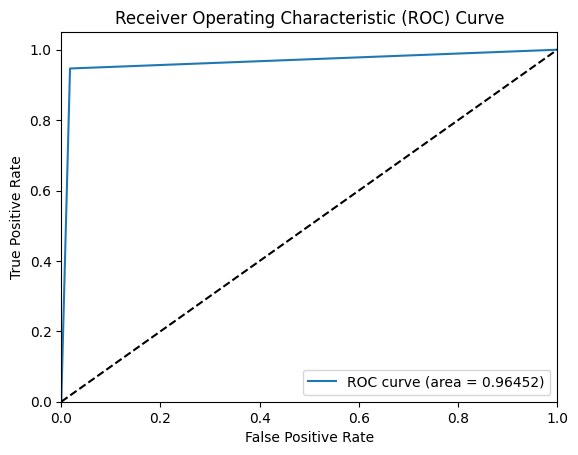

In [83]:
# Calculating ROC the AUC:
fpr, tpr, thresholds = roc_curve(all_true_labels, all_predictions)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.5f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


The ROC curve presented shows that the final classifier performs excellently. The AUC score is very high, 0.96452. 

## Results and Conclusion

The EDA section of this project showed that premium customers are generally satisfied with the airline company, while economy customers are divided. To ensure customer satisfaction, the company should improve economy-class experiences and services. The top three features driving customer satisfaction are `Online Boarding`, `Inflight Wi-Fi Service`, and `Class` (as seen in the feature importance plot). 

The original data set has been processed in several ways and compared to find the settings leading to the best performance. The best-performing preprocessed data encodes ‘Non-Applicable’ services as a separate category. Numerous machine learning models were then implemented, including LDA, KNN, Logistic Regression and Random Forest; however, a Neural Network implemented using PyTorch and manually hyper-tuned achieved the best results.  

The final model was trained with one hundred epochs, and its loss and accuracy curves depicted good model performance and stability. The validation accuracy of this model was 0.96704.  The final model's predictions on the test data set achieved an accuracy score of 0.9667, a precision of 0.97675, and a recall of 0.94668, which is very close to those on the validation set. The consistent results confirm that the model is stable and performs well on new data. The AUC score under the ROC curve was 0.96452, a very high result. 

The extensive preprocessing and hyperparameter tuning did not substantially improve the results compared to the first random forest base model, which had an accuracy of  0.964429, a precision of 0.957307, and a recall of 0.980958. Further efforts could continue indefinitely; for example, removing outliers or other types of feature engineering could be tested. Given the base model's already high accuracy and precision, one has to wonder whether the time-consuming effort would have been financially interesting to the airline.

## References

1. <a id="ref-Geron2023"></a>Aurelian Géron, Hands-On Machine Learning with Scikit-Learn, Keras and TensorFlow (3rd Edition), O'Reilly Media Inc, 20 January 2023.

2. <a id="ref-pytorch2023"></a>PyTorch Contributors, BCEWithLogitsLoss, Pytorch, 2023, [(link)](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html).

3. <a id='ref-pytorch2023'></a>Pytorch Contributors, SGD, Pytorch, 2023, [(link)](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html).

4. <a id='ref-James2015'></a>James Gareth, Daniela Witten, Trevor Hastie and Robert Tibshirani, An Introduction to Statistical Learning, Springer, New York, 2015.